# Partie 1: Avec plateforme tensorflow

In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import LeakyReLU, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
import os, random
# Reproductibilité & GPU
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.keras.utils.set_random_seed(SEED)

try:
    gpus = tf.config.list_physical_devices("GPU")
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except Exception as e:
    print("[WARN] GPU memory growth:", e)

## Définition des hyperparamètres

In [ ]:
BATCH_SIZE   = 128
EPOCHS       = 15
VAL_SPLIT    = 0.1
LR           = 1e-3
IMG_SIZE     = (28, 28)
N_CLASSES    = 10

## Chargement du données

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Split train/validation

In [ ]:
n = x_train.shape[0]
n_val = int(n * VAL_SPLIT)
x_val, y_val   = x_train[:n_val], y_train[:n_val]
x_train, y_train = x_train[n_val:], y_train[n_val:]

## Normalisation [0,1] et ajout de canal (H,W,1)

In [ ]:
def _prep(x, y):
    x = tf.cast(x, tf.float32) / 255.0
    x = tf.expand_dims(x, axis=-1)  # (28,28,1)
    y = tf.cast(y, tf.int32)
    return x, y

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)) \
    .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True) \
    .map(_prep, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)) \
    .map(_prep, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)) \
    .map(_prep, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

## 1) Modèle ReLU (3 conv : 32, 64, 128) avec callbacks

**ReLU (Rectified Linear Unit)** est une fonction d’activation très utilisée dans les réseaux de neurones.  
Elle transforme une valeur d’entrée x selon la règle suivante : f(x)=max(0,x)

Autrement dit, elle garde les valeurs positives inchangées et remplace les valeurs négatives par 0.
Cette fonction introduit de la non-linéarité tout en étant simple et rapide à calculer, ce qui aide le réseau à apprendre des représentations complexes sans souffrir du problème de saturation comme avec la sigmoid ou la tanh.

**Adam (Adaptive Moment Estimation)** est un algorithme d’optimisation utilisé pour ajuster les poids d’un réseau de neurones pendant l’entraînement.
Il combine les avantages de deux autres méthodes :

Momentum (qui garde une mémoire des gradients passés pour accélérer la convergence),

et RMSProp (qui adapte le taux d’apprentissage à chaque paramètre).

### Définition du modèle, de fonction coût et optimiseur

In [ ]:
def build_model(input_shape=(28,28,1), n_classes=10) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=input_shape)
    x = inputs
    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(500, activation="relu")(x)
    x = tf.keras.layers.Dense(120, activation="relu")(x)

    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="mnist_cnn_simple")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
model = build_model((IMG_SIZE[0], IMG_SIZE[1], 1), N_CLASSES)
model.summary()


Model: "mnist_cnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       576,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 120)            │        60,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 730,502 (2.79 MB)

 Trainable params: 730,502 (2.79 MB)

 Non-trainable params: 0 (0.00 B)

### Callbacks

**Les callbacks** sont des fonctions spéciales qui s’exécutent automatiquement pendant l’entraînement du modèle.  
Elles permettent de surveiller, sauvegarder ou ajuster le modèle sans intervention manuelle (ex. : arrêt anticipé, réduction du taux d’apprentissage, sauvegarde du meilleur modèle).

* **EarlyStopping** : arrête l’entraînement si la val_accuracy ne s’améliore pas pendant 3 epochs et restaure les meilleurs poids.

* **ReduceLROnPlateau** : réduit le taux d’apprentissage de moitié si la val_loss stagne pendant 2 epochs, jusqu’à un minimum de 1e−5.

* **ModelCheckpoint** : sauvegarde automatiquement le modèle dans checkpoints/mnist_cnn_simple.keras quand la val_accuracy s’améliore.

In [ ]:
os.makedirs("checkpoints", exist_ok=True)
ckpt_path = os.path.join("checkpoints", "mnist_cnn_simple.keras")

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=3, restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5
    ),
    tf.keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_accuracy", save_best_only=True
    )
]


###  Entraînement du modèle

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 90s 213ms/step - accuracy: 0.9970 - loss: 0.0099 - val_accuracy: 0.9900 - val_loss: 0.0361 - learning_rate: 5.0000e-04
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 203ms/step - accuracy: 0.9979 - loss: 0.0069 - val_accuracy: 0.9917 - val_loss: 0.0331 - learning_rate: 5.0000e-04
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0.9980 - loss: 0.0069 - val_accuracy: 0.9905 - val_loss: 0.0393 - learning_rate: 5.0000e-04
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 203ms/step - accuracy: 0.9986 - loss: 0.0047 - val_accuracy: 0.9908 - val_loss: 0.0371 - learning_rate: 5.0000e-04
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 0.9994 - loss: 0.0024 - val_accuracy: 0.9927 - val_loss: 0.0337 - learning_rate: 2.5000e-04
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 86s 203ms/step - accuracy: 0.9996 - loss: 0.0013 - val_accuracy: 0.9932 - val_loss: 0.0363 - learning_rate: 2.5000e-04
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 90s

### Évaluation test

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")


[Test] loss=0.0241  acc=0.9940


### Courbes de perte et d'accuracy

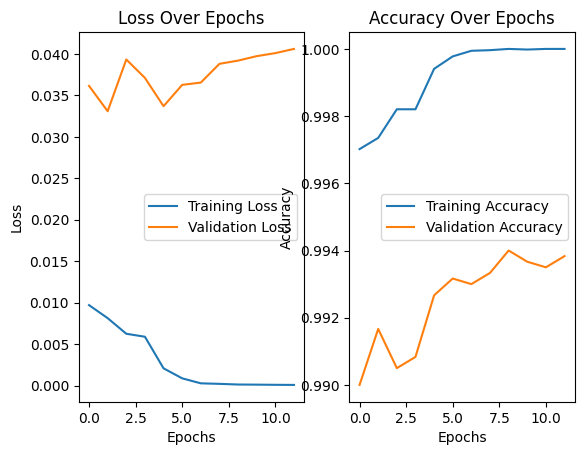

In [ ]:
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Matrice de confusion

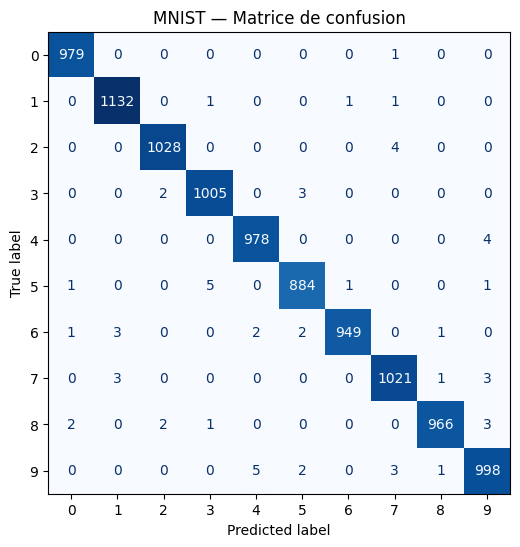

In [ ]:
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(range(N_CLASSES)))
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(N_CLASSES)))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("MNIST — Matrice de confusion")
plt.show()

| Classe réelle | Prédictions incorrectes |                    
|-- | -- |
| 0 | 1 |
| 1 | 3 |
| 2 | 4 |
| 3 | 5 |
| 4 | 4 |
| 5 | 8 |
| 6 | 9 |
| 7 | 7 |
| 8 | 8 |
| 9 | 11 |

Les chiffres les plus mal classés: 9 (confondu avec 4, 7, 5),  6 (confusions avec 1, 4, 5), 8 (confusions avec 9, 0, 2), 5 (confusions avec 3, 6, 9)  



## 2) Modèle ReLU (3 conv : 32, 64, 128) avec callbacks, BatchNormalization et GlobalAveragePooling2D


**La Batch Normalization** normalise les activations de chaque mini-batch (en ajustant la moyenne et la variance), puis les met à l’échelle et les décale, ce qui permet au modèle d’apprendre plus efficacement.

**La GlobalAveragePooling2D** réduit chaque feature map (2D) en une seule valeur en calculant la moyenne de tous ses pixels.

* Elle diminue le nombre de paramètres avant les couches fully connected.

* Elle aide à réduire le surapprentissage tout en conservant l’information globale des features.

### Définition du modèle, fonction de coût et optimiseur

In [ ]:
def build_model(input_shape=(28,28,1), n_classes=10) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=input_shape)

    x = inputs

    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(500, activation="relu")(x)
    x = tf.keras.layers.Dense(120, activation="relu")(x)

    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="mnist_cnn_simple")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


model = build_model((IMG_SIZE[0], IMG_SIZE[1], 1), N_CLASSES)
model.summary()


Model: "mnist_cnn_simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 500)            │        64,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │        60,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 219,398 (857.02 KB)

 Trainable params: 218,950 (855.27 KB)

 Non-trainable params: 448 (1.75 KB)

### Entraînement du modèle

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 137s 315ms/step - accuracy: 0.8750 - loss: 0.3969 - val_accuracy: 0.6945 - val_loss: 1.0265 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 318ms/step - accuracy: 0.9865 - loss: 0.0413 - val_accuracy: 0.9778 - val_loss: 0.0810 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 137s 307ms/step - accuracy: 0.9902 - loss: 0.0308 - val_accuracy: 0.9723 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 132s 284ms/step - accuracy: 0.9937 - loss: 0.0203 - val_accuracy: 0.9847 - val_loss: 0.0529 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 136s 271ms/step - accuracy: 0.9955 - loss: 0.0156 - val_accuracy: 0.9873 - val_loss: 0.0431 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 275ms/step - accuracy: 0.9940 - loss: 0.0170 - val_accuracy: 0.9842 - val_loss: 0.0533 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 140s 270ms/step - accura

### Evaluation test

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")


[Test] loss=0.0307  acc=0.9935


### Courbes de perte et d'accuracy

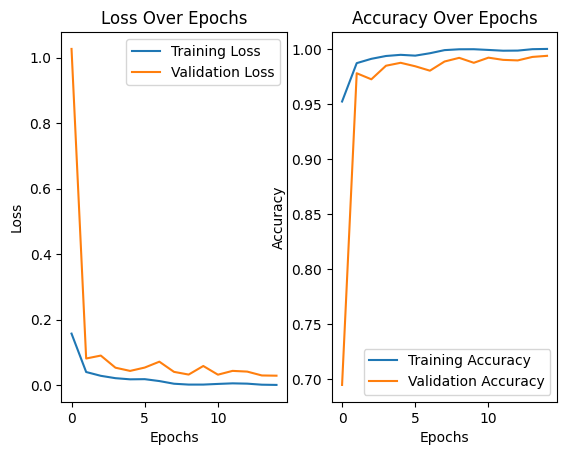

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Les courbes montrent une baisse rapide de la perte d’entraînement et une précision proche de 100 %. La perte de validation augmente légèrement, indiquant un léger surapprentissage. Les performances globales restent très bonnes.

### Matrice de confusion

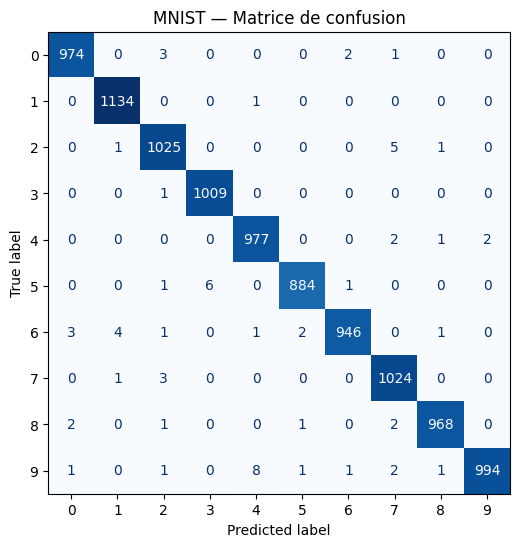

In [ ]:
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(range(N_CLASSES)))
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(N_CLASSES)))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("MNIST — Matrice de confusion")
plt.show()

| Classe réelle | Prédictions incorrectes |                    
|-- | -- |
| 0 | 6 |
| 1 | 1 |
| 2 | 7 |
| 3 | 1 |
| 4 | 5 |
| 5 | 8 |
| 6 | 12 |
| 7 | 4 |
| 8 | 6 |
| 9 | 15 |

Les chiffres les plus mal classés: 9 (confondu avec 4, 7),  6 (confusions avec 1, 0)



### Rapport de classification

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9939    0.9939    0.9939       980
           1     0.9947    0.9991    0.9969      1135
           2     0.9894    0.9932    0.9913      1032
           3     0.9941    0.9990    0.9965      1010
           4     0.9899    0.9949    0.9924       982
           5     0.9955    0.9910    0.9933       892
           6     0.9958    0.9875    0.9916       958
           7     0.9884    0.9961    0.9922      1028
           8     0.9959    0.9938    0.9949       974
           9     0.9980    0.9851    0.9915      1009

    accuracy                         0.9935     10000
   macro avg     0.9936    0.9934    0.9935     10000
weighted avg     0.9935    0.9935    0.9935     10000



Les performances du modèle sont très élevées, avec une précision globale (accuracy) de 99,35 % sur l’ensemble de test.
Les métriques de précision (precision), de rappel (recall) et de f1-score sont toutes supérieures à 0,98 pour chaque classe, ce qui montre que le modèle reconnaît correctement la quasi-totalité des chiffres manuscrits.

## 3) Modèle ReLU (4 conv : 32, 64, 128, 256) avec callbacks, Data Augmantation, BatchNormalization et Dropout

**Le Dropout** est une technique de régularisation qui désactive aléatoirement un pourcentage de neurones pendant l’entraînement.

Cela réduit le surapprentissage et force le réseau à apprendre des représentations plus robustes.

### Data Augmentation

**La Data Augmentation** consiste à modifier artificiellement les données d’entraînement (ex. rotations, translations, zoom, flips) pour augmenter la diversité du dataset.
Cela réduit le surapprentissage et améliore la généralisation du modèle.

In [ ]:
data_augment = tf.keras.Sequential([
    tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
    tf.keras.layers.RandomRotation(0.05, fill_mode="nearest"),
])

### Définition du modèle, fonction coût et optimiseur

In [ ]:

def build_model(input_shape=(28,28,1), n_classes=10) -> tf.keras.Model:
    inputs = tf.keras.Input(shape=input_shape)

    x = data_augment(inputs)

    x = tf.keras.layers.Conv2D(32, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPool2D()(x)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.2)(x)


    outputs = tf.keras.layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="mnist_cnn_simple")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


model = build_model((IMG_SIZE[0], IMG_SIZE[1], 1), N_CLASSES)
# model.summary()


### Entraînement du modèle

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 163s 377ms/step - accuracy: 0.8424 - loss: 0.5224 - val_accuracy: 0.9532 - val_loss: 0.1625 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 221s 422ms/step - accuracy: 0.9747 - loss: 0.0873 - val_accuracy: 0.9872 - val_loss: 0.0437 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 163s 386ms/step - accuracy: 0.9802 - loss: 0.0690 - val_accuracy: 0.9882 - val_loss: 0.0397 - learning_rate: 0.0010
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 157s 373ms/step - accuracy: 0.9846 - loss: 0.0519 - val_accuracy: 0.9887 - val_loss: 0.0380 - learning_rate: 0.0010
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 164s 388ms/step - accuracy: 0.9854 - loss: 0.0476 - val_accuracy: 0.9892 - val_loss: 0.0360 - learning_rate: 0.0010
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 176s 416ms/step - accuracy: 0.9876 - loss: 0.0422 - val_accuracy: 0.9887 - val_loss: 0.0411 - learning_rate: 0.0010
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 190s 389ms/step - accura

### Evaluation test

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\n[Test] loss={test_loss:.4f}  acc={test_acc:.4f}")


[Test] loss=0.0152  acc=0.9957


### Courbes de perte et d'accuracy

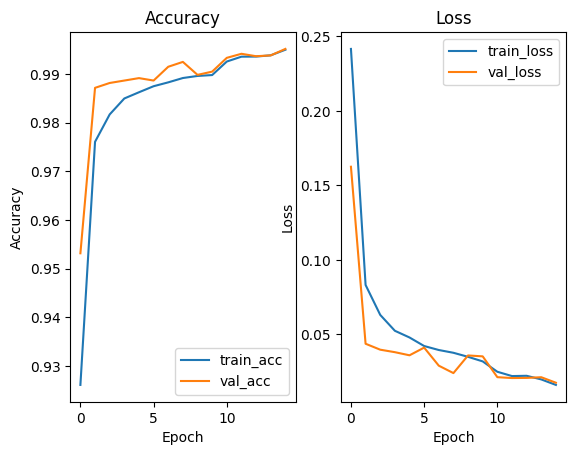

In [ ]:
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title(f'Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title(f'Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Matrice de confusion

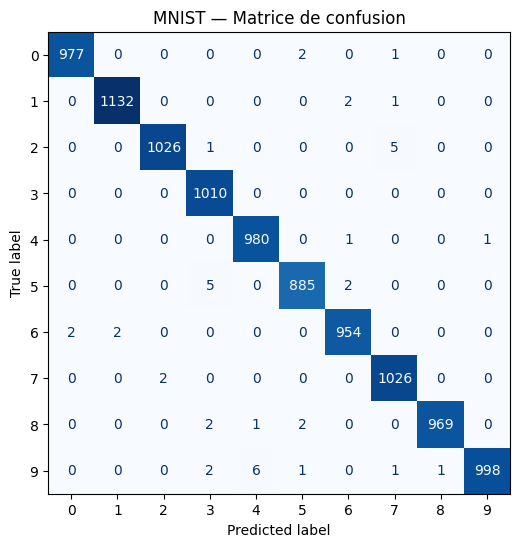

In [ ]:
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_test, y_pred, labels=list(range(N_CLASSES)))
disp = ConfusionMatrixDisplay(cm, display_labels=list(range(N_CLASSES)))
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("MNIST — Matrice de confusion")
plt.show()

### Rapport de clasification

In [ ]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9980    0.9969    0.9974       980
           1     0.9982    0.9974    0.9978      1135
           2     0.9981    0.9942    0.9961      1032
           3     0.9902    1.0000    0.9951      1010
           4     0.9929    0.9980    0.9954       982
           5     0.9944    0.9922    0.9933       892
           6     0.9948    0.9958    0.9953       958
           7     0.9923    0.9981    0.9952      1028
           8     0.9990    0.9949    0.9969       974
           9     0.9990    0.9891    0.9940      1009

    accuracy                         0.9957     10000
   macro avg     0.9957    0.9956    0.9957     10000
weighted avg     0.9957    0.9957    0.9957     10000



Le modèle atteint une accuracy de 99,57 %, ce qui montre une excellente performance sur le dataset MNIST.  
Les valeurs de precision, recall et f1-score sont proches de 1 pour toutes les classes, indiquant une bonne stabilité.  
Les rares erreurs concernent surtout le chiffre 9, parfois confondu avec le 4 ou le 7.  
Dans l’ensemble, le modèle reconnaît correctement presque tous les chiffres.

## Définition de  trois architectures différentes

### **1. CNN simple**
* 2 conv + 1 dense
* Activation ReLU
* ReLU f(x) = max(0, x) est très efficace et rapide à entraîner.
* Elle évite le problème du gradient qui disparaît (comme avec sigmoid).
* Suffisante pour un petit modèle.


### **2. CNN intermédiaire**
* 3 conv + 2 dense + BatchNorm + Dropout
* Activation LeakyReLU
* Évite le problème des neurones “morts” de ReLU (valeurs bloquées à 0).
* Améliore légèrement la stabilité et la précision.
* Bon compromis entre performance et vitesse.


### **3. CNN profond**
* conv + 3 dense + BatchNorm + Dropout + data augmentation
* Activation GELU
* GELU (Gaussian Error Linear Unit) offre une meilleure **lissage du gradient**, souvent utilisé dans les architectures modernes (comme BERT).






**LeakyReLU** est une variante de ReLU qui laisse passer une petite pente pour les valeurs négatives au lieu de les mettre à zéro.

Cela évite le problème de neurones morts et améliore l’apprentissage.

**GELU** est une fonction d’activation qui combine ReLU et une probabilité gaussienne, activant les neurones de manière lisse et continue.

Elle est souvent utilisée dans les transformers et améliore légèrement la performance par rapport à ReLU ou LeakyReLU.

### Fonctions pour construire les modèles

In [ ]:
def cnn_simple(input_shape=(28,28,1), n_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, activation='relu')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_intermediate(input_shape=(28,28,1), n_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='leaky_relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='leaky_relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def cnn_deep(input_shape=(28,28,1), n_classes=10):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, 3, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('gelu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='gelu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### Fonction d'entraînement et évaluation

In [ ]:
def train_and_evaluate(model, name, use_augmentation=False, epochs=15):
    if use_augmentation:
        data_augment = tf.keras.Sequential([
            tf.keras.layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
            tf.keras.layers.RandomRotation(0.05, fill_mode="nearest"),
        ])
        inputs = tf.keras.Input(shape=(28,28,1))
        x = data_augment(inputs)
        outputs = model(x)
        model_to_train = tf.keras.Model(inputs=inputs, outputs=outputs)

        model_to_train.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
    else:
      model_to_train = model


    # Entraînement
    history = model_to_train.fit(train_ds, epochs=epochs, validation_data=val_ds, verbose=1)

    # Évaluation test
    test_loss, test_acc = model_to_train.evaluate(test_ds)
    print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

    # Prédictions
    y_pred = model_to_train.predict(test_ds)
    y_pred = np.argmax(y_pred, axis=1)

    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred, labels=list(range(N_CLASSES)))
    disp = ConfusionMatrixDisplay(cm, display_labels=list(range(N_CLASSES)))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("MNIST — Matrice de confusion")
    plt.show()

    # Rapport de classification
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # Courbes d'accuracy et loss
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.title(f'Accuracy - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'Loss - {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


### Exécution de CNN simple

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 49s 113ms/step - accuracy: 0.8370 - loss: 0.5309 - val_accuracy: 0.9765 - val_loss: 0.0775
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 84s 118ms/step - accuracy: 0.9796 - loss: 0.0674 - val_accuracy: 0.9805 - val_loss: 0.0635
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 49s 115ms/step - accuracy: 0.9854 - loss: 0.0455 - val_accuracy: 0.9858 - val_loss: 0.0469
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 52s 123ms/step - accuracy: 0.9896 - loss: 0.0342 - val_accuracy: 0.9848 - val_loss: 0.0469
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 98s 162ms/step - accuracy: 0.9911 - loss: 0.0250 - val_accuracy: 0.9878 - val_loss: 0.0384
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 68s 129ms/step - accuracy: 0.9932 - loss: 0.0211 - val_accuracy: 0.9895 - val_loss: 0.0367
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 49s 115ms/step - accuracy: 0.9949 - loss: 0.0143 - val_accuracy: 0.9882 - val_loss: 0.0371
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 85s 123ms/step - accuracy: 0.9959 - loss: 0

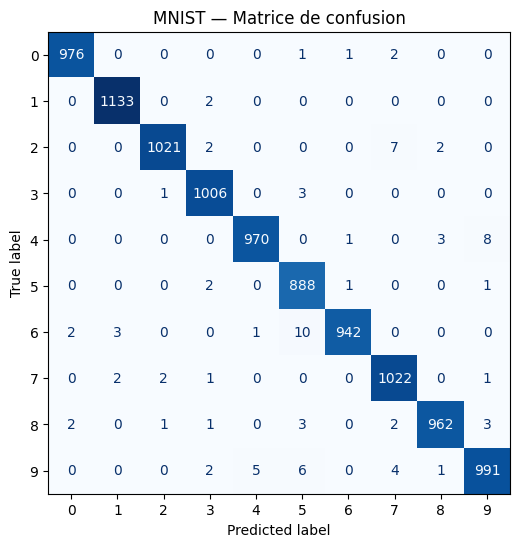

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.97      1.00      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



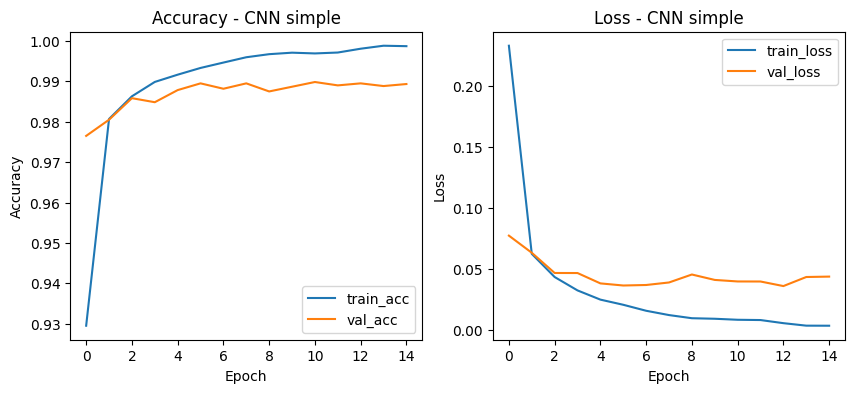

In [ ]:
train_and_evaluate(cnn_simple(), "CNN simple")

### Exécution de CNN intermédiaire

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 173s 398ms/step - accuracy: 0.8430 - loss: 0.5055 - val_accuracy: 0.7860 - val_loss: 0.6823
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 153s 363ms/step - accuracy: 0.9794 - loss: 0.0705 - val_accuracy: 0.9865 - val_loss: 0.0479
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 183s 317ms/step - accuracy: 0.9844 - loss: 0.0506 - val_accuracy: 0.9895 - val_loss: 0.0418
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 155s 347ms/step - accuracy: 0.9873 - loss: 0.0401 - val_accuracy: 0.9877 - val_loss: 0.0490
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 321ms/step - accuracy: 0.9906 - loss: 0.0289 - val_accuracy: 0.9832 - val_loss: 0.0585
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 313ms/step - accuracy: 0.9918 - loss: 0.0256 - val_accuracy: 0.9862 - val_loss: 0.0532
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 137s 325ms/step - accuracy: 0.9929 - loss: 0.0229 - val_accuracy: 0.9897 - val_loss: 0.0322
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 138s 316ms/step - accuracy: 0.9944 -

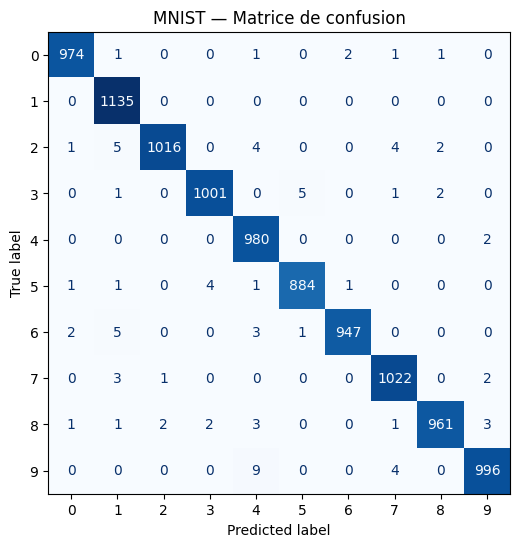

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.98      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



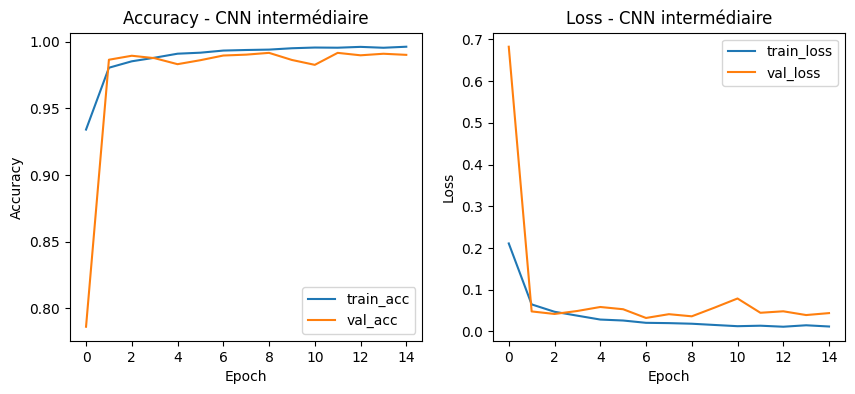

In [ ]:
train_and_evaluate(cnn_intermediate(), "CNN intermédiaire")

### Exécution de CNN profond

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 234s 541ms/step - accuracy: 0.7879 - loss: 0.6489 - val_accuracy: 0.9778 - val_loss: 0.1061
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 243s 496ms/step - accuracy: 0.9707 - loss: 0.1048 - val_accuracy: 0.9807 - val_loss: 0.0685
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 269s 512ms/step - accuracy: 0.9772 - loss: 0.0814 - val_accuracy: 0.9875 - val_loss: 0.0463
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 195s 462ms/step - accuracy: 0.9841 - loss: 0.0571 - val_accuracy: 0.9888 - val_loss: 0.0405
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 218s 514ms/step - accuracy: 0.9856 - loss: 0.0493 - val_accuracy: 0.9887 - val_loss: 0.0393
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 227s 538ms/step - accuracy: 0.9868 - loss: 0.0463 - val_accuracy: 0.9848 - val_loss: 0.0548
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 236s 477ms/step - accuracy: 0.9875 - loss: 0.0437 - val_accuracy: 0.9920 - val_loss: 0.0291
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 205s 484ms/step - accuracy: 0.9885 -

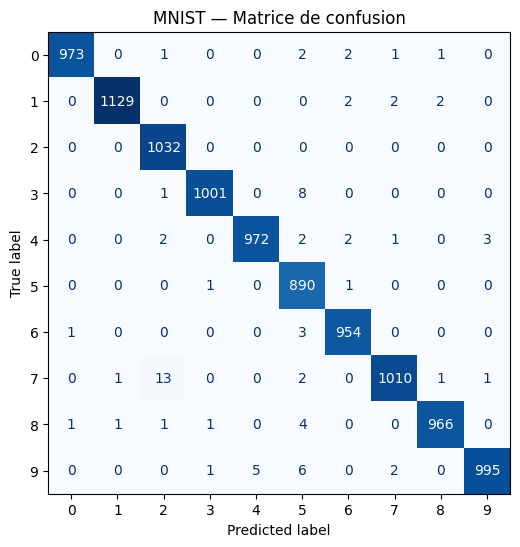

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       980
           1       1.00      0.99      1.00      1135
           2       0.98      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.97      1.00      0.98       892
           6       0.99      1.00      0.99       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



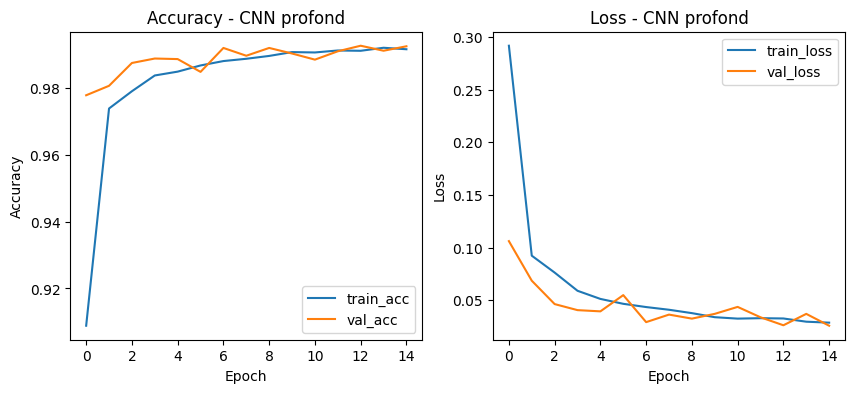

In [ ]:
train_and_evaluate(cnn_deep(), "CNN profond", use_augmentation=True)

### Observations :

1. **Performances :**

   * Tous les modèles atteignent déjà plus de 99 % de précision sur MNIST.
   * Le modèle profond avec GELU et data augmentation a légèrement **la meilleure précision** et la **perte la plus faible**, ce qui montre l’avantage des architectures plus complexes et de l’augmentation de données.

2. **Activation :**

   * **ReLU** : rapide et efficace, suffisant pour des modèles simples.
   * **LeakyReLU** : évite les neurones morts et améliore la stabilité.
   * **GELU** : lissage du gradient, utile dans les architectures modernes, améliore légèrement la précision.

3. **Régularisation :**

   * BatchNorm + Dropout dans les modèles intermédiaire et profond améliore la **stabilité de l’entraînement** et **réduit le surapprentissage**.
   * Data augmentation dans le modèle profond renforce la robustesse.


## 4) Modèle LeakyReLU sans Batch Normalization (3 conv : 32, 64, 128)

### Définition du modèle

In [ ]:
model_leaky_3conv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Fonction coût et optimiseur

In [ ]:
model_leaky_3conv.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraîment et évaluation

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 96s 222ms/step - accuracy: 0.8551 - loss: 0.4732 - val_accuracy: 0.9820 - val_loss: 0.0616
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 225ms/step - accuracy: 0.9823 - loss: 0.0541 - val_accuracy: 0.9860 - val_loss: 0.0448
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 108s 255ms/step - accuracy: 0.9891 - loss: 0.0345 - val_accuracy: 0.9897 - val_loss: 0.0347
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 130s 227ms/step - accuracy: 0.9920 - loss: 0.0256 - val_accuracy: 0.9887 - val_loss: 0.0391
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 225ms/step - accuracy: 0.9929 - loss: 0.0205 - val_accuracy: 0.9873 - val_loss: 0.0434
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 227ms/step - accuracy: 0.9956 - loss: 0.0146 - val_accuracy: 0.9890 - val_loss: 0.0406
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 98s 232ms/step - accuracy: 0.9964 - loss: 0.0115 - val_accuracy: 0.9892 - val_loss: 0.0398
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 137s 221ms/step - accuracy: 0.9964 - l

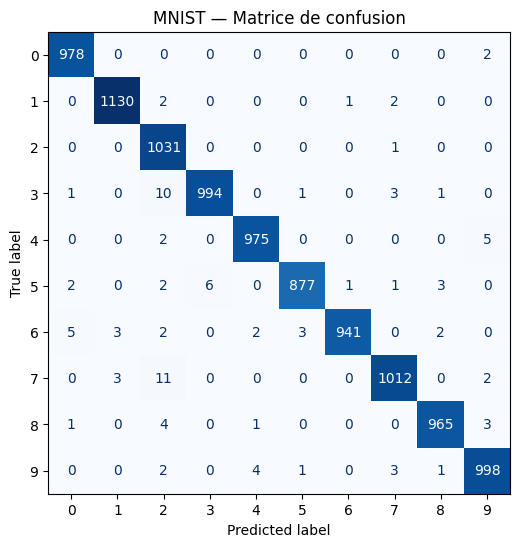

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      1.00      1135
           2       0.97      1.00      0.98      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



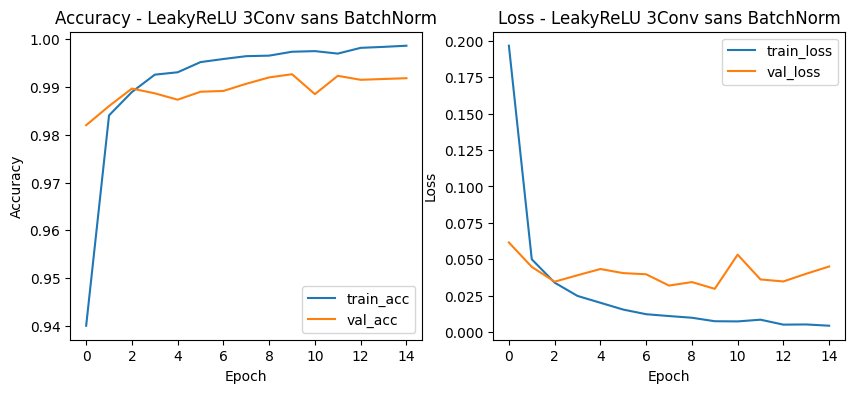

In [ ]:
train_and_evaluate(model_leaky_3conv, "LeakyReLU 3Conv sans BatchNorm")

Le modèle atteint une très bonne performance avec une accuracy de 0.9901 et une loss faible (0.0421). Les scores de précision, rappel et F1-score sont proches de 0.99 pour toutes les classes, indiquant que les prédictions sont globalement fiables et équilibrées. Quelques classes présentent un rappel légèrement inférieur, ce qui montre que certaines erreurs subsistent.

## 5) Modèle GELU sans Batch Normalization (3 conv : 32, 64, 128)

### Définition du modèle

In [ ]:
model_gelu_3conv = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Activation('gelu'),

    tf.keras.layers.Dense(10, activation='softmax')
])


### Fonction coût et optimiseur

In [ ]:
model_gelu_3conv.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraînement et évaluation

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 331ms/step - accuracy: 0.8089 - loss: 0.5884 - val_accuracy: 0.9822 - val_loss: 0.0619
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 339ms/step - accuracy: 0.9818 - loss: 0.0595 - val_accuracy: 0.9880 - val_loss: 0.0438
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 336ms/step - accuracy: 0.9890 - loss: 0.0359 - val_accuracy: 0.9882 - val_loss: 0.0402
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 337ms/step - accuracy: 0.9918 - loss: 0.0252 - val_accuracy: 0.9917 - val_loss: 0.0320
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 204s 341ms/step - accuracy: 0.9952 - loss: 0.0149 - val_accuracy: 0.9887 - val_loss: 0.0425
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 144s 342ms/step - accuracy: 0.9945 - loss: 0.0161 - val_accuracy: 0.9903 - val_loss: 0.0314
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 147s 348ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9905 - val_loss: 0.0334
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 142s 338ms/step - accuracy: 0.9970 -

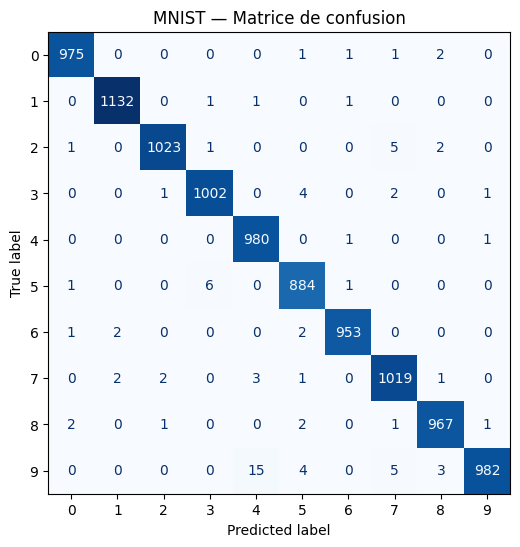

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.98      1.00      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.99      1.00       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.97      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



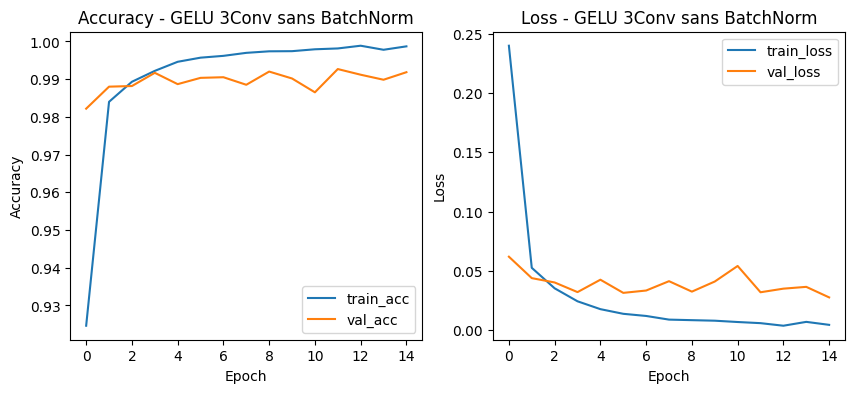

In [ ]:
train_and_evaluate(model_gelu_3conv, "GELU 3Conv sans BatchNorm")

Le modèle montre des performances avec une accuracy de 0.9917 et une loss faible (0.0377). Les métriques de précision, rappel et F1-score sont très élevées pour toutes les classes. On remarque que certaines classes (comme la 9) ont un rappel légèrement inférieur (0.97), suggérant que quelques erreurs persistent.

## 6) Modèle LeakyReLU avec Batch Normalization (3 conv : 32, 64, 128)

### Définition du modèle

In [ ]:
model_leaky_3conv_bn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(alpha=0.1),

    tf.keras.layers.Dense(10, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


### Fonction coût et optimiseur

In [ ]:
model_leaky_3conv_bn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraînement et évaluation

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 328ms/step - accuracy: 0.9350 - loss: 0.2316 - val_accuracy: 0.6282 - val_loss: 1.3679
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 132s 313ms/step - accuracy: 0.9913 - loss: 0.0312 - val_accuracy: 0.9747 - val_loss: 0.0813
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 141s 310ms/step - accuracy: 0.9949 - loss: 0.0191 - val_accuracy: 0.9838 - val_loss: 0.0519
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 140s 333ms/step - accuracy: 0.9965 - loss: 0.0125 - val_accuracy: 0.9885 - val_loss: 0.0388
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 143s 336ms/step - accuracy: 0.9972 - loss: 0.0098 - val_accuracy: 0.9895 - val_loss: 0.0328
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 139s 329ms/step - accuracy: 0.9975 - loss: 0.0081 - val_accuracy: 0.9843 - val_loss: 0.0543
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 131s 311ms/step - accuracy: 0.9974 - loss: 0.0080 - val_accuracy: 0.9898 - val_loss: 0.0352
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 140s 305ms/step - accuracy: 0.9983 -

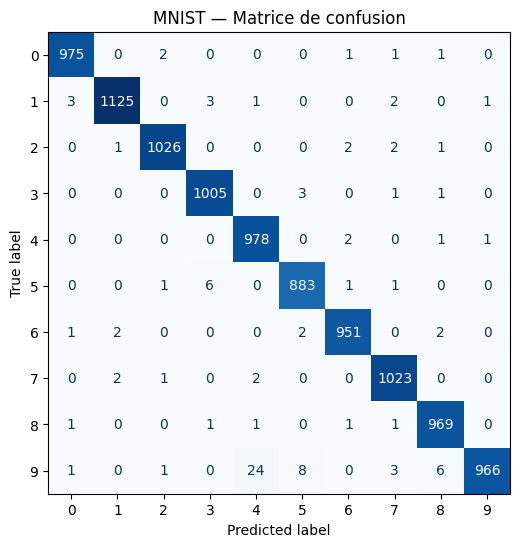

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       1.00      0.99      0.99      1032
           3       0.99      1.00      0.99      1010
           4       0.97      1.00      0.98       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.96      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



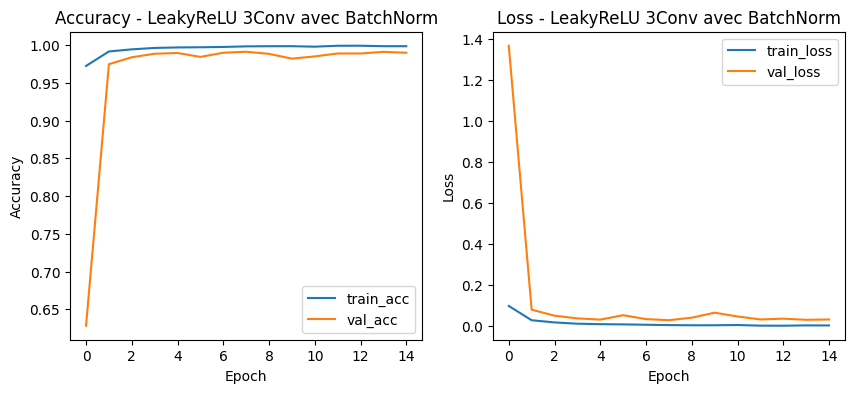

In [ ]:
train_and_evaluate(model_leaky_3conv_bn, "LeakyReLU 3Conv avec BatchNorm")

Le modèle converge très rapidement et atteint une excellente précision (99%) sur les deux ensembles, ce qui indique un apprentissage efficace et une bonne généralisation.
La chute rapide du val_loss dès la première epoch montre que le modèle apprend rapidement à généraliser. La stabilisation autour d’une valeur très faible indique que le modèle est performant et bien régularisé, probablement grâce à la BatchNorm et à l’utilisation de LeakyReLU.

## 7) Modèle GELU avec Batch Normalization (3 conv : 32, 64, 128)

### Définition du modèle

In [ ]:
model_gelu_3conv_bn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

### Fonction coût et optimiseur

In [ ]:
model_gelu_3conv_bn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraînement et évaluaion

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 199s 463ms/step - accuracy: 0.9386 - loss: 0.2218 - val_accuracy: 0.2680 - val_loss: 2.4502
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 198s 453ms/step - accuracy: 0.9918 - loss: 0.0298 - val_accuracy: 0.9793 - val_loss: 0.0636
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 200s 448ms/step - accuracy: 0.9950 - loss: 0.0185 - val_accuracy: 0.9832 - val_loss: 0.0513
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 201s 445ms/step - accuracy: 0.9965 - loss: 0.0120 - val_accuracy: 0.9860 - val_loss: 0.0457
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 216s 479ms/step - accuracy: 0.9970 - loss: 0.0102 - val_accuracy: 0.9903 - val_loss: 0.0288
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 191s 453ms/step - accuracy: 0.9972 - loss: 0.0083 - val_accuracy: 0.9793 - val_loss: 0.0721
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 190s 449ms/step - accuracy: 0.9982 - loss: 0.0071 - val_accuracy: 0.9903 - val_loss: 0.0363
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 203s 452ms/step - accuracy: 0.9986 -

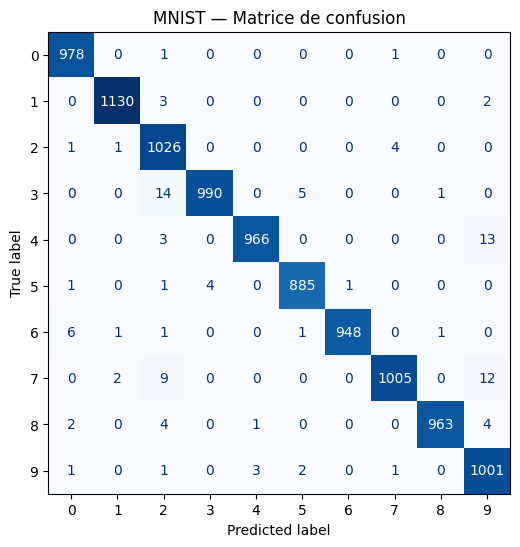

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       0.97      0.99      0.98      1032
           3       1.00      0.98      0.99      1010
           4       1.00      0.98      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.97      0.99      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



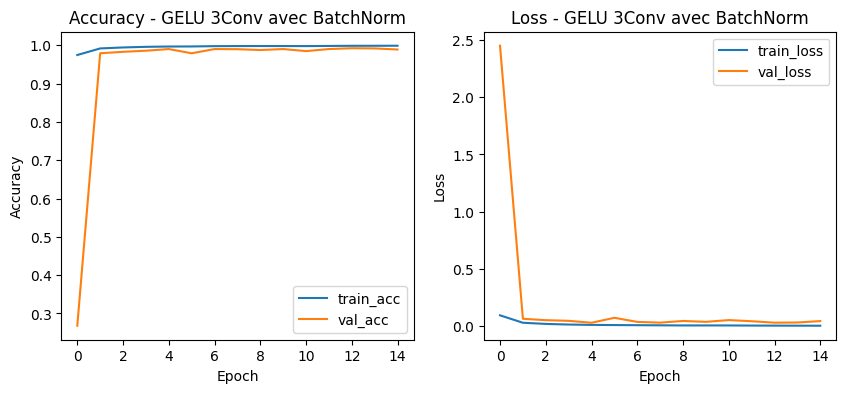

In [ ]:
train_and_evaluate(model_gelu_3conv_bn, "GELU 3Conv avec BatchNorm")

## 8) Modèle GELU avec Batch Normalization (3 conv : 32, 64, 128)

### Définition du modèle

In [ ]:
model_gelu_3conv_bn = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),

    tf.keras.layers.Conv2D(32, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(64, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(128, (3,3), padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('gelu'),

    tf.keras.layers.Dense(10, activation='softmax')
])

### Fonction coût et optimiseur

In [ ]:
model_gelu_3conv_bn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraînement et évaluation

Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 189s 436ms/step - accuracy: 0.9418 - loss: 0.2095 - val_accuracy: 0.2463 - val_loss: 2.1353
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 184s 436ms/step - accuracy: 0.9913 - loss: 0.0296 - val_accuracy: 0.9887 - val_loss: 0.0348
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 184s 437ms/step - accuracy: 0.9952 - loss: 0.0166 - val_accuracy: 0.9907 - val_loss: 0.0289
Epoch 4/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 209s 453ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9890 - val_loss: 0.0358
Epoch 5/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 190s 451ms/step - accuracy: 0.9978 - loss: 0.0073 - val_accuracy: 0.9915 - val_loss: 0.0295
Epoch 6/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 184s 436ms/step - accuracy: 0.9971 - loss: 0.0090 - val_accuracy: 0.9918 - val_loss: 0.0279
Epoch 7/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 208s 449ms/step - accuracy: 0.9978 - loss: 0.0075 - val_accuracy: 0.9918 - val_loss: 0.0275
Epoch 8/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 186s 441ms/step - accuracy: 0.9988 -

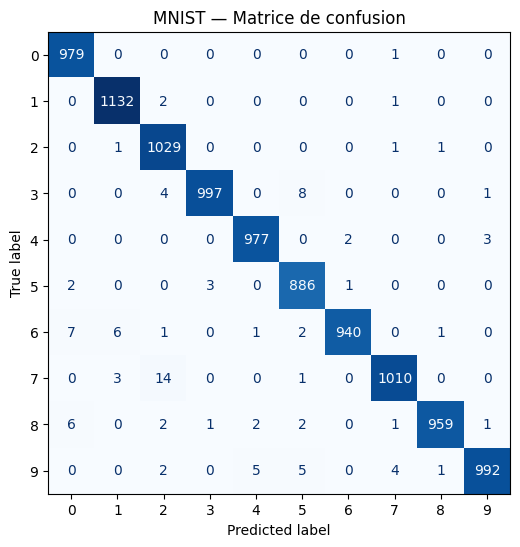

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      1.00      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.98      0.99      0.99       892
           6       1.00      0.98      0.99       958
           7       0.99      0.98      0.99      1028
           8       1.00      0.98      0.99       974
           9       0.99      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



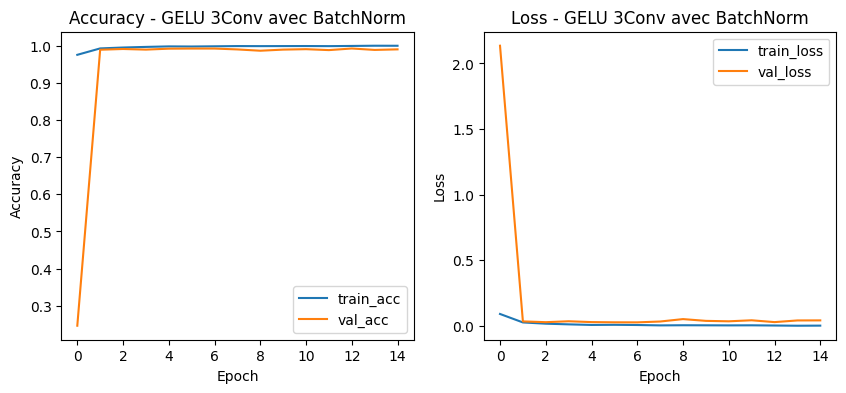

In [ ]:
train_and_evaluate(model_gelu_3conv_bn, "GELU 3Conv avec BatchNorm")

# Partie 2 : Utilisation de PyTorch

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

## Hyperparamètres

In [41]:
BATCH_SIZE = 128
EPOCHS = 15
VAL_SPLIT = 0.1
LR = 1e-3
IMG_SIZE = (28, 28)
N_CLASSES = 10


In [42]:
SEED = 42
torch.manual_seed(SEED)
CKPT_PATH = "checkpoints/mnist_cnn_simple.pth"
os.makedirs("checkpoints", exist_ok=True)

## Chargement de MNIST

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 335kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.17MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.24MB/s]


## Division train / validation

In [ ]:
n_val = int(len(dataset) * VAL_SPLIT)
n_train = len(dataset) - n_val
train_ds, val_ds = random_split(dataset, [n_train, n_val])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

## Fonction d'entraînement et évaluation

In [ ]:
def train_and_evaluate(model, name, train_dataset, val_dataset, test_dataset, epochs=EPOCHS, batch_size=BATCH_SIZE, lr=LR, patience_es=3, patience_lr=2, factor_lr=0.5, min_lr=1e-5,checkpoint_path=CKPT_PATH, use_augmentation=False):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if use_augmentation:
        transform_aug = transforms.Compose([
            transforms.RandomRotation(10),
            transforms.RandomAffine(0, translate=(0.05, 0.05)),
            transforms.ToTensor()
        ])
        train_dataset.transform = transform_aug

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_acc, val_acc, train_loss, val_loss = [], [], [], []
    best_val_acc = 0.0
    es_counter = 0
    current_lr = lr

    for epoch in range(epochs):
        # Entraînement
        model.train()
        correct, total, running_loss = 0, 0, 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        # Validation
        model.eval()
        val_correct, val_total, val_running_loss = 0, 0, 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == yb).sum().item()
                val_total += yb.size(0)
        val_loss.append(val_running_loss / len(val_loader))
        val_acc.append(val_correct / val_total)

        print(f"Epoch [{epoch+1}/{epochs}], train acc: {train_acc[-1]:.4f}, val acc: {val_acc[-1]:.4f}, train loss: {train_loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}")

        # ModelCheckpoint
        if val_acc[-1] > best_val_acc:
            best_val_acc = val_acc[-1]
            torch.save(model.state_dict(), checkpoint_path)
            es_counter = 0
        else:
            es_counter += 1

        # ReduceLROnPlateau
        if es_counter >= patience_lr:
            current_lr = max(current_lr * factor_lr, min_lr)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr
            es_counter = 0

        # EarlyStopping
        if es_counter >= patience_es:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break

    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    # Evaluation test
    y_true, y_pred = [], []
    test_correct, test_total, test_running_loss = 0, 0, 0.0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            loss = criterion(outputs, yb)
            test_running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == yb).sum().item()
            test_total += yb.size(0)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    test_loss = test_running_loss / len(test_loader)
    test_acc = test_correct / test_total
    print(f"\n\n test accuracy: {test_acc:.4f}, test loss: {test_loss:.4f}\n\n")

    # Courbes d'accuracy et loss
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title("Loss over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.title("Accuracy over epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Matrice de confusion
    cm = confusion_matrix(y_true, y_pred, labels=list(range(N_CLASSES)))
    disp = ConfusionMatrixDisplay(cm, display_labels=list(range(N_CLASSES)))
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    plt.title("MNIST — Confusion Matrix ({name})")
    plt.show()

    # Rapport de classification
    print(classification_report(y_true, y_pred))


## 1) CNN simple (ReLU) 2 conv + 1 dense

### Définition du modèle

In [ ]:
class CNNSimple(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNSimple, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, n_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x
model = CNNSimple(n_classes=N_CLASSES)


### Entraînement et évaluation du modèle

Epoch [1/15], train acc: 0.9275, val acc: 0.9698, train loss: 0.2497, val loss: 0.1061
Epoch [2/15], train acc: 0.9809, val acc: 0.9837, train loss: 0.0621, val loss: 0.0547
Epoch [3/15], train acc: 0.9864, val acc: 0.9812, train loss: 0.0425, val loss: 0.0621
Epoch [4/15], train acc: 0.9903, val acc: 0.9867, train loss: 0.0307, val loss: 0.0448
Epoch [5/15], train acc: 0.9919, val acc: 0.9858, train loss: 0.0247, val loss: 0.0452
Epoch [6/15], train acc: 0.9935, val acc: 0.9888, train loss: 0.0193, val loss: 0.0400
Epoch [7/15], train acc: 0.9954, val acc: 0.9892, train loss: 0.0149, val loss: 0.0382
Epoch [8/15], train acc: 0.9954, val acc: 0.9872, train loss: 0.0139, val loss: 0.0439
Epoch [9/15], train acc: 0.9965, val acc: 0.9895, train loss: 0.0108, val loss: 0.0377
Epoch [10/15], train acc: 0.9971, val acc: 0.9865, train loss: 0.0091, val loss: 0.0562
Epoch [11/15], train acc: 0.9975, val acc: 0.9880, train loss: 0.0080, val loss: 0.0450
Epoch [12/15], train acc: 0.9994, val acc

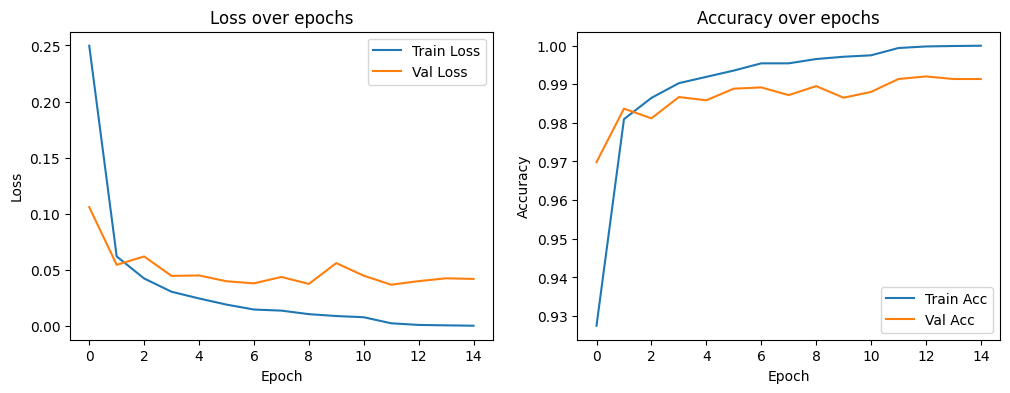

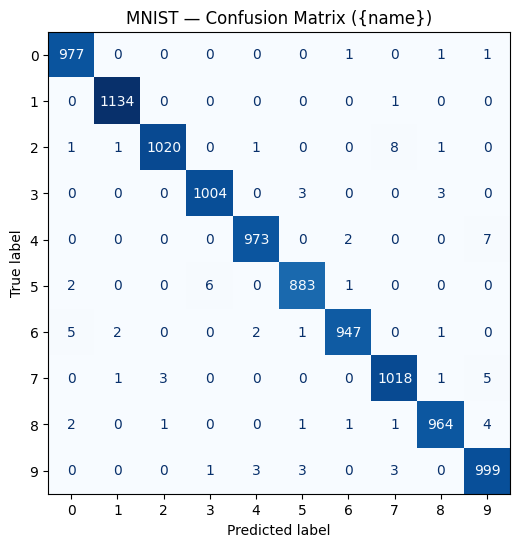

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.98      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_evaluate(model, "CNN simple", train_ds, val_ds, test_dataset)

## 2) CNN intermédiaire (LeakyReLU) 3 conv + 2 dense + BatchNorm + Dropout

### Définition du modèle

In [ ]:
class CNNIntermediate(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNIntermediate, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return x
model = CNNIntermediate(n_classes=N_CLASSES)


### Entraînement et évaluation

Epoch [1/15], train acc: 0.9412, val acc: 0.9798, train loss: 0.1903, val loss: 0.0663
Epoch [2/15], train acc: 0.9836, val acc: 0.9878, train loss: 0.0548, val loss: 0.0393
Epoch [3/15], train acc: 0.9884, val acc: 0.9865, train loss: 0.0390, val loss: 0.0427
Epoch [4/15], train acc: 0.9903, val acc: 0.9873, train loss: 0.0331, val loss: 0.0518
Epoch [5/15], train acc: 0.9948, val acc: 0.9927, train loss: 0.0170, val loss: 0.0274
Epoch [6/15], train acc: 0.9964, val acc: 0.9907, train loss: 0.0130, val loss: 0.0384
Epoch [7/15], train acc: 0.9962, val acc: 0.9885, train loss: 0.0127, val loss: 0.0520
Epoch [8/15], train acc: 0.9978, val acc: 0.9937, train loss: 0.0079, val loss: 0.0254
Epoch [9/15], train acc: 0.9986, val acc: 0.9922, train loss: 0.0047, val loss: 0.0299
Epoch [10/15], train acc: 0.9987, val acc: 0.9927, train loss: 0.0044, val loss: 0.0266
Epoch [11/15], train acc: 0.9991, val acc: 0.9935, train loss: 0.0032, val loss: 0.0285
Epoch [12/15], train acc: 0.9994, val acc

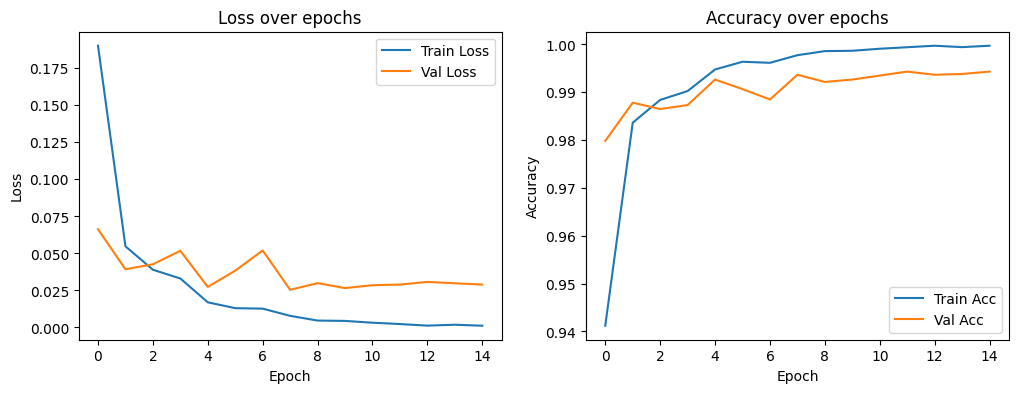

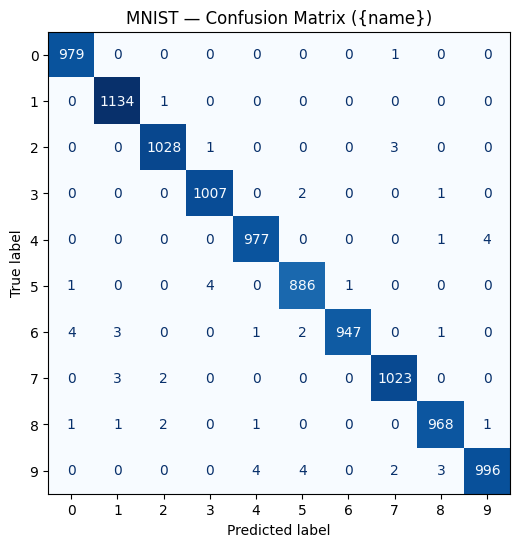

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      0.99      0.99       974
           9       1.00      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_evaluate(model, "CNN Intermediate", train_ds, val_ds, test_dataset)

## 3) CNN profond (GELU) conv + 3 dense + BatchNorm + Dropout + data augmentation


### Définition du modèle

In [ ]:
class CNNDeep(nn.Module):
    def __init__(self, n_classes=10):
        super(CNNDeep, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)

        self.fc1 = nn.Linear(128 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc_out = nn.Linear(128, n_classes)
        self.dropout = nn.Dropout(0.3)
        self.gelu = nn.GELU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.gelu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.gelu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.gelu(x)
        x = self.pool3(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.fc_out(x)

        return x
model = CNNDeep(n_classes=N_CLASSES)

### Entraînement et évaluation

Epoch [1/15], train acc: 0.9480, val acc: 0.9862, train loss: 0.1675, val loss: 0.0463
Epoch [2/15], train acc: 0.9847, val acc: 0.9850, train loss: 0.0553, val loss: 0.0538
Epoch [3/15], train acc: 0.9879, val acc: 0.9913, train loss: 0.0420, val loss: 0.0332
Epoch [4/15], train acc: 0.9906, val acc: 0.9897, train loss: 0.0332, val loss: 0.0371
Epoch [5/15], train acc: 0.9920, val acc: 0.9888, train loss: 0.0288, val loss: 0.0459
Epoch [6/15], train acc: 0.9961, val acc: 0.9928, train loss: 0.0146, val loss: 0.0285
Epoch [7/15], train acc: 0.9972, val acc: 0.9927, train loss: 0.0096, val loss: 0.0298
Epoch [8/15], train acc: 0.9974, val acc: 0.9923, train loss: 0.0096, val loss: 0.0327
Epoch [9/15], train acc: 0.9989, val acc: 0.9943, train loss: 0.0047, val loss: 0.0349
Epoch [10/15], train acc: 0.9989, val acc: 0.9935, train loss: 0.0038, val loss: 0.0387
Epoch [11/15], train acc: 0.9991, val acc: 0.9928, train loss: 0.0038, val loss: 0.0363
Epoch [12/15], train acc: 0.9995, val acc

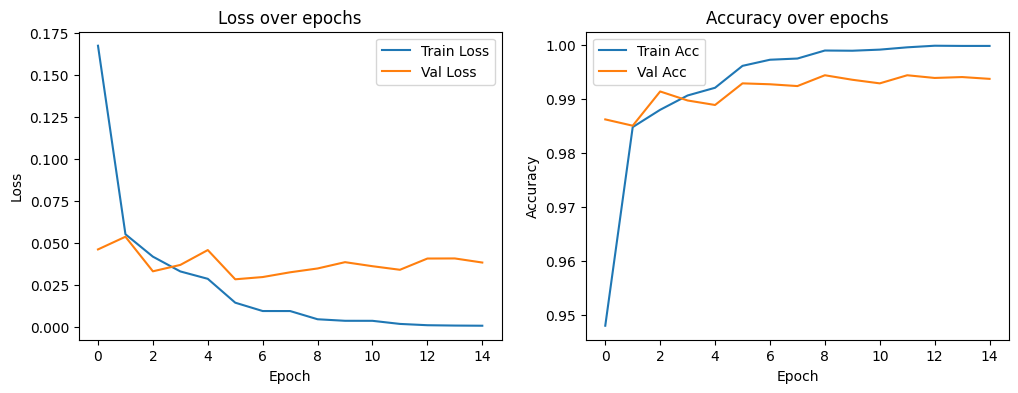

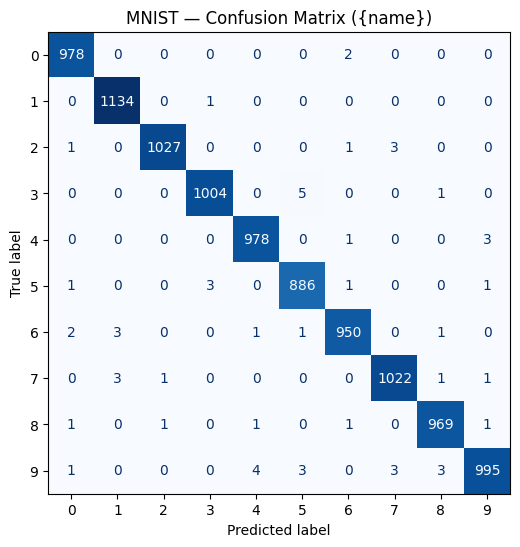

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      1.00      1.00      1032
           3       1.00      0.99      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_evaluate(model,"CNN Deep avec augmentation", train_ds, val_ds, test_dataset, use_augmentation=True)

## Comparaison :

## 4) Modèle ReLU (3 conv : 32, 64, 128) avec callbacks

### Définition du modèle

In [ ]:
class model1(nn.Module):
    def __init__(self, input_channels=1, n_classes=10):
        super(model1, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self._to_linear = 128 * (IMG_SIZE[0]//8) * (IMG_SIZE[1]//8)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, 500),
            nn.ReLU(),
            nn.Linear(500, 120),
            nn.ReLU(),
            nn.Linear(120, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
model = model1(n_classes=N_CLASSES)

### Entraînement et évaluation

Epoch [1/15], train acc: 0.9963, val acc: 0.9905, train loss: 0.0112, val loss: 0.0343
Epoch [2/15], train acc: 0.9971, val acc: 0.9895, train loss: 0.0086, val loss: 0.0431
Epoch [3/15], train acc: 0.9973, val acc: 0.9922, train loss: 0.0091, val loss: 0.0363
Epoch [4/15], train acc: 0.9974, val acc: 0.9902, train loss: 0.0083, val loss: 0.0344
Epoch [5/15], train acc: 0.9982, val acc: 0.9922, train loss: 0.0056, val loss: 0.0355
Epoch [6/15], train acc: 0.9994, val acc: 0.9942, train loss: 0.0015, val loss: 0.0330
Epoch [7/15], train acc: 0.9999, val acc: 0.9942, train loss: 0.0004, val loss: 0.0323
Epoch [8/15], train acc: 1.0000, val acc: 0.9943, train loss: 0.0001, val loss: 0.0332
Epoch [9/15], train acc: 1.0000, val acc: 0.9943, train loss: 0.0000, val loss: 0.0345
Epoch [10/15], train acc: 1.0000, val acc: 0.9938, train loss: 0.0000, val loss: 0.0356
Epoch [11/15], train acc: 1.0000, val acc: 0.9940, train loss: 0.0000, val loss: 0.0361
Epoch [12/15], train acc: 1.0000, val acc

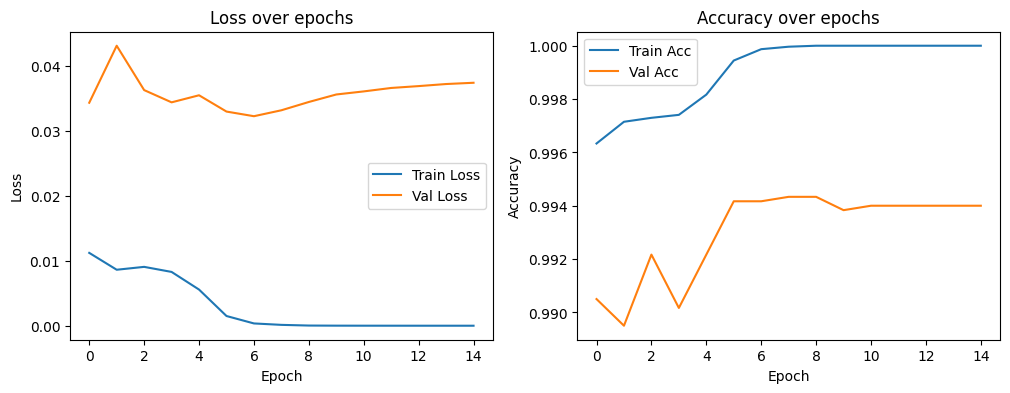

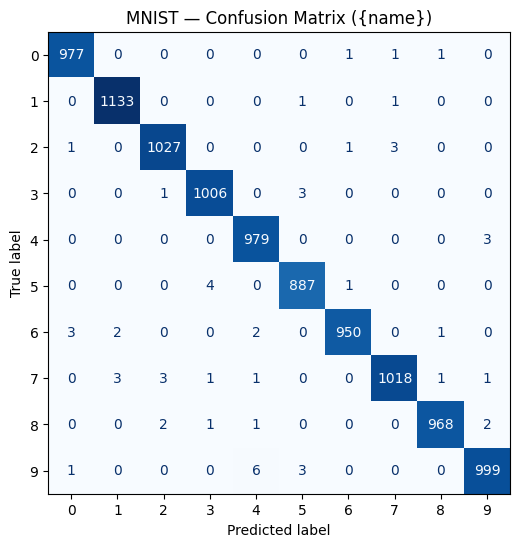

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       0.99      1.00      0.99      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       1.00      0.99      0.99      1028
           8       1.00      0.99      1.00       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_evaluate(model, "model1", train_ds, val_ds, test_dataset)

## 3) Modèle ReLU (4 conv : 32, 64, 128, 256) avec callbacks, Data Augmantation, BatchNormalization et Dropout

### Définition du modèle

In [ ]:
class MNIST_CNN_Aug(nn.Module):
    def __init__(self, input_channels=1, n_classes=10, dropout_rate=0.2):
        super(MNIST_CNN_Aug, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2),
        )

        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.global_avg_pool(x)
        x = self.fc(x)
        return x

model = MNIST_CNN_Aug(n_classes=N_CLASSES)


### Entraînement et évaluation

Epoch [1/15], train acc: 0.9616, val acc: 0.9842, train loss: 0.1331, val loss: 0.0561
Epoch [2/15], train acc: 0.9869, val acc: 0.9882, train loss: 0.0428, val loss: 0.0396
Epoch [3/15], train acc: 0.9913, val acc: 0.9908, train loss: 0.0302, val loss: 0.0318
Epoch [4/15], train acc: 0.9931, val acc: 0.9893, train loss: 0.0232, val loss: 0.0361
Epoch [5/15], train acc: 0.9943, val acc: 0.9902, train loss: 0.0187, val loss: 0.0345
Epoch [6/15], train acc: 0.9971, val acc: 0.9940, train loss: 0.0086, val loss: 0.0235
Epoch [7/15], train acc: 0.9984, val acc: 0.9945, train loss: 0.0052, val loss: 0.0236
Epoch [8/15], train acc: 0.9988, val acc: 0.9948, train loss: 0.0044, val loss: 0.0246
Epoch [9/15], train acc: 0.9992, val acc: 0.9928, train loss: 0.0029, val loss: 0.0284
Epoch [10/15], train acc: 0.9982, val acc: 0.9918, train loss: 0.0063, val loss: 0.0293
Epoch [11/15], train acc: 0.9990, val acc: 0.9945, train loss: 0.0030, val loss: 0.0263
Epoch [12/15], train acc: 0.9998, val acc

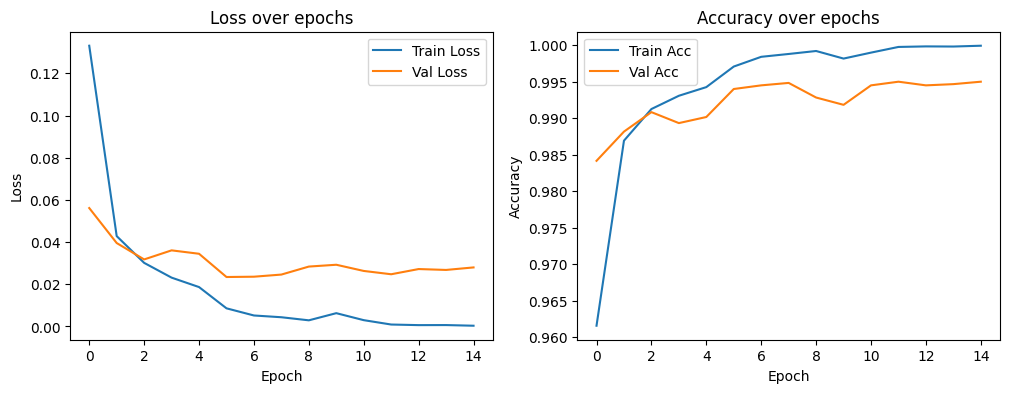

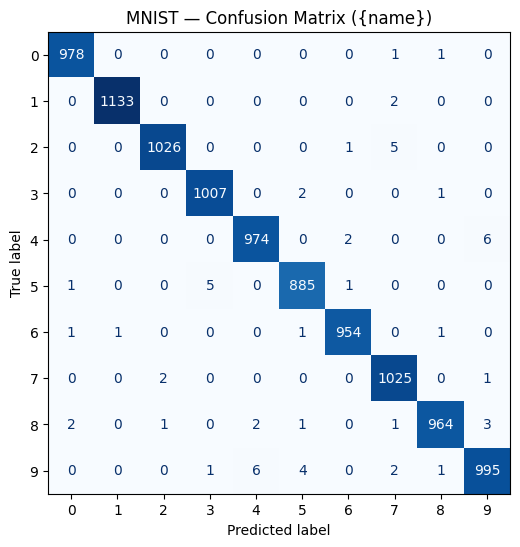

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       1.00      1.00      1.00       958
           7       0.99      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [ ]:
train_and_evaluate(model,"mnist_cnn_aug", train_ds, val_ds, test_dataset, use_augmentation=True)

Le modèle atteint une performance avec une accuracy de 99,41 % et une perte de 0,0269, montrant une bonne généralisation sur l’ensemble de test. Les métriques de précision, rappel et F1-score proches de 1.00 confirment la robustesse du modèle sur toutes les classes MNIST.

## Conlusion:

L’ensemble des modèles entraînés ont atteint une accuracy supérieure ou égale à 99 %. Cependant, le modèle **ReLU**, composé de quatre couches convolutionnelles **(32, 64, 128 et 256 filtres)**, a présenté les meilleures performances globales.
Grâce à l’intégration des **callbacks**, de la **Data Augmentation**, de la **BatchNormalization** et du **Dropout**, ce modèle développé sous TensorFlow a obtenu une loss de **0,0152** et une accuracy de **99,57%**.

# Partie 3 : Classification des fruits

10 Class : Apple, Kiwi, Banana, Cherry, Orange, Mango, Avocado, Pinenapple, Strawberries

In [ ]:
# Importation de la clé d’API Kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"souhailaelaarej","key":"2f80e601fdb8a4d5ec8d58b9df4a7815"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
# Téléchargement de dataset depuis Kaggle
!kaggle datasets download -d moltean/fruits
!unzip -q fruits.zip -d fruits_dataset


Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.53G/4.54G [00:58<00:00, 122MB/s]
100% 4.54G/4.54G [00:58<00:00, 82.8MB/s]


In [ ]:
!ls /content/fruits_dataset/fruits-360_100x100/fruits-360

LICENSE  README.md  Test  Training


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Hyperparamètres

In [57]:
IMG_SIZE = (100, 100)
BATCH_SIZE = 32
LR = 1e-3
EPOCHS = 15
SEED = 42

### Chargement du dataset

In [58]:
train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=SEED
)
val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=SEED
)
test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2301 files belonging to 10 classes.
Using 1841 files for training.
Found 2301 files belonging to 10 classes.
Using 460 files for validation.
Found 1025 files belonging to 10 classes.


###  Récupération des noms et le nombre de classes

In [59]:
class_names = train_ds.class_names
N_CLASSES = len(class_names)
print("Classes détectées :", class_names)
print("Nombre de classes :", N_CLASSES)

Classes détectées : ['Apple', 'Banana', 'avocado', 'cherry', 'kiwi', 'mango', 'orange', 'pinenapple', 'strawberries', 'watermelon']
Nombre de classes : 10


### Affichage de quelques images du jeu d'entraînement

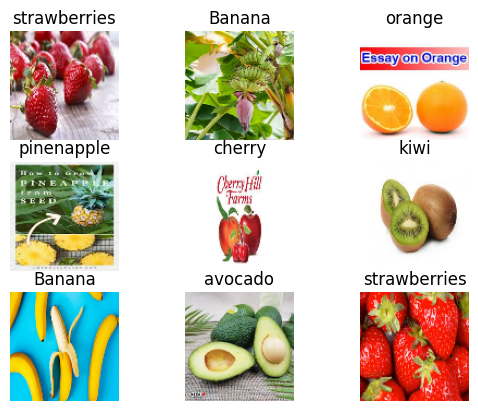

In [ ]:
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()


### Normalisation des pixels


In [60]:
train_ds = train_ds.map(lambda x, y: (x/255.0, y)).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (x/255.0, y)).cache().prefetch(tf.data.AUTOTUNE)

## 1) Modèle ReLU (4 conv : 32, 64, 128, 256) avec callbacks, Data Augmantation, BatchNormalization et Dropout par tensorflow

### Data augmentation

In [61]:
data_augment = tf.keras.Sequential([
    layers.RandomTranslation(0.05, 0.05, fill_mode="nearest"),
    layers.RandomRotation(0.05, fill_mode="nearest"),
])

### Construction du modèle avec fonction coût et optimiseur

In [62]:
def build_model(input_shape=(100, 100, 3), n_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augment(inputs)

    for filters in [32, 64, 128, 256]:
        x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(n_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs, name="fruit_cnn_relu")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_model((IMG_SIZE[0], IMG_SIZE[1], 3), N_CLASSES)
model.summary()

Model: "fruit_cnn_relu"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 424,522 (1.62 MB)

 Trainable params: 423,562 (1.62 MB)

 Non-trainable params: 960 (3.75 KB)

### Callbacks

In [63]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
]

### Entraînement

In [64]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,callbacks=callbacks,verbose=1)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 14s 66ms/step - accuracy: 0.2188 - loss: 2.5611 - val_accuracy: 0.1304 - val_loss: 2.5077 - learning_rate: 0.0010
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.3696 - loss: 1.7966 - val_accuracy: 0.1283 - val_loss: 2.8620 - learning_rate: 0.0010
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4252 - loss: 1.6543 - val_accuracy: 0.1522 - val_loss: 2.9234 - learning_rate: 0.0010
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4530 - loss: 1.5333
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.4533 - loss: 1.5330 - val_accuracy: 0.1587 - val_loss: 2.8911 - learning_rate: 0.0010
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5121 - loss: 1.4181 - val_accuracy: 0.2522 - val_loss: 2.8052 - learning_rate: 5.0000e-04
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5411 - loss: 1.3398 - val

### Évaluation

In [65]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\ntest loss = {test_loss:.4f}, accuracy = {test_acc:.4f}")


test loss = 1.6229, accuracy = 0.5132


### Courbes d'accuracy et loss

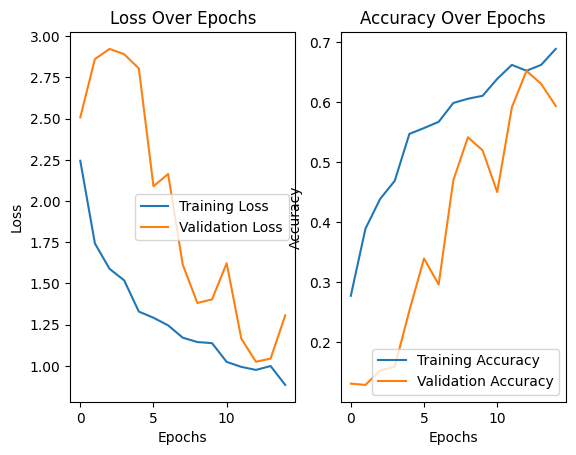

In [66]:
# Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### Matrice de confusion

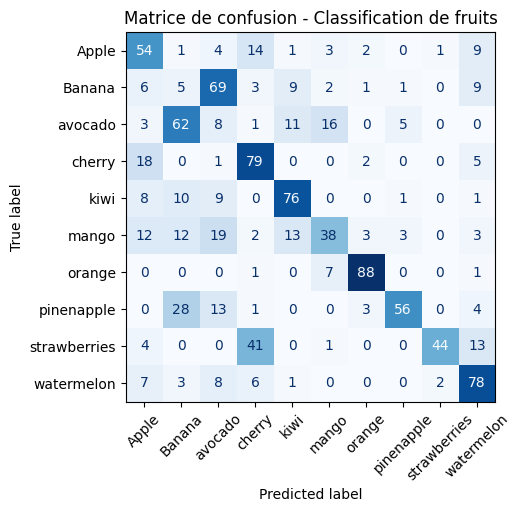

In [67]:
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_prob = model.predict(test_ds, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap="Blues", colorbar=False, xticks_rotation=45)
plt.title("Matrice de confusion - Classification de fruits")
plt.show()

### Rapport de classification

In [68]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.48      0.61      0.54        89
           1       0.04      0.05      0.04       105
           2       0.06      0.08      0.07       106
           3       0.53      0.75      0.62       105
           4       0.68      0.72      0.70       105
           5       0.57      0.36      0.44       105
           6       0.89      0.91      0.90        97
           7       0.85      0.53      0.65       105
           8       0.94      0.43      0.59       103
           9       0.63      0.74      0.68       105

    accuracy                           0.51      1025
   macro avg       0.57      0.52      0.52      1025
weighted avg       0.57      0.51      0.52      1025



## 2) Modèle ReLU (3 conv : 32, 64, 128) avec Data Augmantation, BatchNormalization et Dropout par tensorflow

### Construction du modèle

In [55]:
data_augment = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomTranslation(0.05, 0.05)
])

def build_fruit_cnn(input_shape=(100, 100, 3), n_classes=10):
    inputs = tf.keras.Input(shape=input_shape)

    x = data_augment(inputs)

    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="fruit_cnn")

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_fruit_cnn((IMG_SIZE[0], IMG_SIZE[1], 3), N_CLASSES)
model.summary()


Model: "fruit_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,454,858 (9.36 MB)

 Trainable params: 2,454,410 (9.36 MB)

 Non-trainable params: 448 (1.75 KB)

### Entraînement

In [69]:
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS,verbose=1)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.6781 - loss: 0.8815 - val_accuracy: 0.6435 - val_loss: 1.1133
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6803 - loss: 0.9572 - val_accuracy: 0.6391 - val_loss: 1.1202
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7167 - loss: 0.8469 - val_accuracy: 0.5935 - val_loss: 1.2422
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7261 - loss: 0.7708 - val_accuracy: 0.5457 - val_loss: 1.6219
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7450 - loss: 0.7522 - val_accuracy: 0.6391 - val_loss: 1.1435
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7003 - loss: 0.8039 - val_accuracy: 0.6174 - val_loss: 1.1831
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7557 - loss: 0.6876 - val_accuracy: 0.6130 - val_loss: 1.1616
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.7623 - loss: 0.6854 - val_accuracy: 0.5174 - v

### Evaluation sur test set

In [70]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\ntest loss = {test_loss:.4f}, accuracy = {test_acc:.4f}")


test loss = 2.1966, accuracy = 0.5502


## 3) Modèle LeakyReLU (3 conv : 32, 64, 128) avec BatchNormalization et Dropout par Pytorch

### Hyperparamètres


In [43]:
BATCH_SIZE = 64
EPOCHS = 15
LR = 1e-3
IMG_SIZE = (100,100)
SEED = 42
torch.manual_seed(SEED)

### Transformations

In [44]:
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomRotation(5),
    transforms.RandomAffine(0, translate=(0.05,0.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Chargement du dataset

In [45]:
train_dataset_full = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/fruits/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/Colab Notebooks/fruits/test', transform=test_transform)
N_CLASSES = len(train_dataset_full.classes)

# Split train/val
val_size = int(0.2 * len(train_dataset_full))
train_size = len(train_dataset_full) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset_full, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


### Définition du modèle

In [46]:
class LeakyReLU_CNN(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(128*12*12, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = LeakyReLU_CNN(n_classes=N_CLASSES)

### Fonction coût et optimiseur

In [47]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

### Entraînement

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LeakyReLU_CNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Dropout(p

In [49]:
train_loss, val_loss = [], []
train_acc, val_acc = [], []

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader)
    epoch_train_acc = correct / total

    # Validation
    model.eval()
    val_running_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    epoch_val_loss = val_running_loss / len(val_loader)
    epoch_val_acc = val_correct / val_total

    train_loss.append(epoch_train_loss)
    val_loss.append(epoch_val_loss)
    train_acc.append(epoch_train_acc)
    val_acc.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}], train acc: {train_acc[-1]:.4f}, val acc: {val_acc[-1]:.4f}, train loss: {train_loss[-1]:.4f}, val loss: {val_loss[-1]:.4f}")


Epoch [1/15], train acc: 0.2406, val acc: 0.3783, train loss: 3.5298, val loss: 1.6912
Epoch [2/15], train acc: 0.3916, val acc: 0.4717, train loss: 1.6088, val loss: 1.4413
Epoch [3/15], train acc: 0.4492, val acc: 0.4783, train loss: 1.4765, val loss: 1.4250
Epoch [4/15], train acc: 0.4943, val acc: 0.4630, train loss: 1.3827, val loss: 1.3533
Epoch [5/15], train acc: 0.5291, val acc: 0.5870, train loss: 1.2895, val loss: 1.2009
Epoch [6/15], train acc: 0.5801, val acc: 0.6000, train loss: 1.1724, val loss: 1.1280
Epoch [7/15], train acc: 0.6143, val acc: 0.6283, train loss: 1.0917, val loss: 1.0779
Epoch [8/15], train acc: 0.6502, val acc: 0.5239, train loss: 0.9983, val loss: 1.2108
Epoch [9/15], train acc: 0.6388, val acc: 0.6087, train loss: 0.9702, val loss: 1.0638
Epoch [10/15], train acc: 0.6681, val acc: 0.6522, train loss: 0.9118, val loss: 1.0264
Epoch [11/15], train acc: 0.7137, val acc: 0.5957, train loss: 0.8261, val loss: 1.1463
Epoch [12/15], train acc: 0.7083, val acc

### Evaluation sur le test set

In [51]:
model.eval()
test_correct, test_total, test_loss_sum = 0, 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = test_correct / test_total
test_loss = test_loss_sum / len(test_loader)

print(f"Test accuracy: {test_acc:.4f}, Test loss: {test_loss:.4f}")


Test accuracy: 0.4810, Test loss: 2.3546


### Matrice de confussion

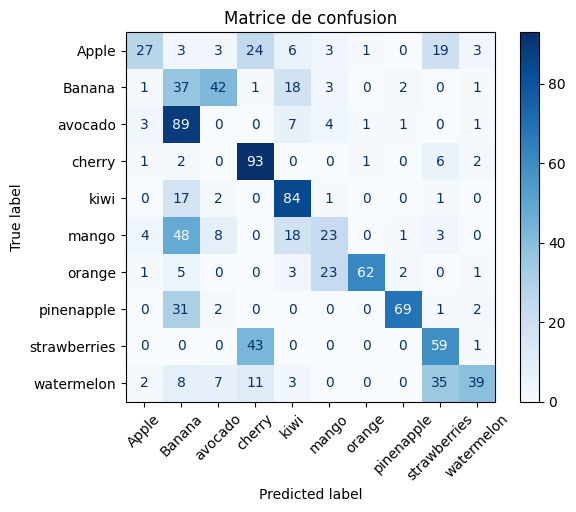

In [52]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset_full.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Matrice de confusion")
plt.show()

### Rapport de classification

In [53]:
print(classification_report(all_labels, all_preds, target_names=train_dataset_full.classes))


              precision    recall  f1-score   support

       Apple       0.69      0.30      0.42        89
      Banana       0.15      0.35      0.21       105
     avocado       0.00      0.00      0.00       106
      cherry       0.54      0.89      0.67       105
        kiwi       0.60      0.80      0.69       105
       mango       0.40      0.22      0.28       105
      orange       0.95      0.64      0.77        97
  pinenapple       0.92      0.66      0.77       105
strawberries       0.48      0.57      0.52       103
  watermelon       0.78      0.37      0.50       105

    accuracy                           0.48      1025
   macro avg       0.55      0.48      0.48      1025
weighted avg       0.55      0.48      0.48      1025



### Courbes de perte et d’accuracy

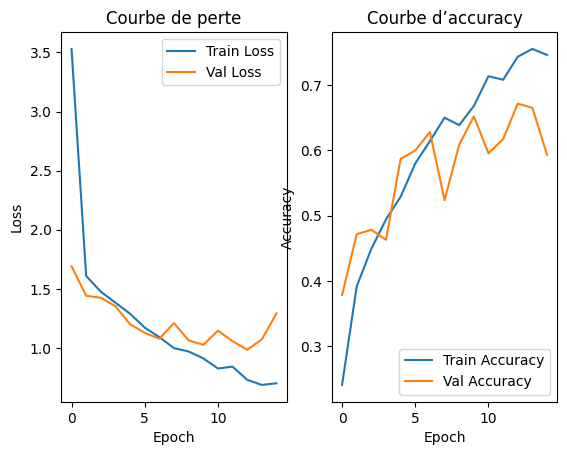

In [54]:
plt.subplot(1,2,1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title("Courbe de perte")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.title("Courbe d’accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

## Conclusion

Après avoir expérimenté plusieurs architectures CNN pour la **classification des fruits**, j’ai obtenu les résultats suivants :

* **Modèle ReLU (4 conv : 32, 64, 128, 256)** avec *callbacks*, *Data Augmentation*, *BatchNormalization* et *Dropout* sous **TensorFlow** :
   *test loss* = **1.6229**, *test accuracy* = **0.5132**

* **Modèle ReLU (3 conv : 32, 64, 128)** avec *Data Augmentation*, *BatchNormalization* et *Dropout* sous **TensorFlow** :
*test loss* = **2.1966**, *test accuracy* = **0.5502**

* **Modèle LeakyReLU (3 conv : 32, 64, 128)** avec *BatchNormalization* et *Dropout* sous **PyTorch** :
*test loss* = **2.3546**, *test accuracy* = **0.4810**

Ces résultats montrent que les modèles CNN développés manuellement offrent une précision moyenne. Ils parviennent à apprendre certaines caractéristiques visuelles des fruits, mais leurs performances restent limitées, notamment face à la variabilité des images (lumière, angle, texture, etc.).

Afin d’améliorer la performance du système de classification, nous avons ensuite expérimenté des modèles profonds et préentraînés, notamment VGG16 et ResNet50, qui permettent de tirer parti des connaissances acquises sur de grands ensembles de données (comme ImageNet) et d’obtenir de meilleures performances de généralisation.

## 4) VGG16

**VGG16** est un réseau de neurones convolutif profond (CNN) avec 16 couches apprenantes : 13 couches convolutionnelles et 3 couches fully connected.

Il utilise des filtres très petits (3×3) et des couches de pooling 2×2 pour extraire progressivement les caractéristiques des images.

L’architecture est très régulière et simple, ce qui facilite sa reproduction et son utilisation.

Grâce à sa profondeur et à ses petits filtres, il capture des détails fins et complexes dans les images.

Il est largement utilisé comme modèle pré-entraîné pour le transfert learning, surtout dans les tâches de classification et de détection d’objets.

Bien que performant, il est relativement lourd en paramètres (~138 millions), ce qui peut nécessiter beaucoup de mémoire et de calcul.

In [ ]:
from tensorflow.keras.applications import VGG16

### Chargement du dataset

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="training",
    seed=42
)
val_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    subset="validation",
    seed=42
)
test_ds = image_dataset_from_directory(
    "/content/drive/MyDrive/Colab Notebooks/fruits/test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 2301 files belonging to 10 classes.
Using 1841 files for training.
Found 2301 files belonging to 10 classes.
Using 460 files for validation.
Found 1025 files belonging to 10 classes.


In [ ]:
# Prétraitement
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

### Chargement du modèle VGG16
On gèle les couches convolutionnelles

In [ ]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

### Construction du modèle

In [ ]:
model = models.Sequential([
    tf.keras.Input(shape=(128, 128, 3)),
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

### Fonction coût et optimiseur

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

### Entraînement

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=15)

Epoch 1/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 553s 10s/step - accuracy: 0.1768 - loss: 29.3943 - val_accuracy: 0.4935 - val_loss: 5.8897
Epoch 2/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 550s 10s/step - accuracy: 0.5045 - loss: 6.9798 - val_accuracy: 0.5565 - val_loss: 3.8963
Epoch 3/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 546s 9s/step - accuracy: 0.6174 - loss: 3.6580 - val_accuracy: 0.5978 - val_loss: 3.0543
Epoch 4/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 532s 9s/step - accuracy: 0.7209 - loss: 2.0572 - val_accuracy: 0.6109 - val_loss: 2.7178
Epoch 5/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 540s 9s/step - accuracy: 0.7841 - loss: 1.1855 - val_accuracy: 0.6435 - val_loss: 2.5784
Epoch 6/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 529s 9s/step - accuracy: 0.8375 - loss: 0.8314 - val_accuracy: 0.6543 - val_loss: 2.4576
Epoch 7/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 487s 8s/step - accuracy: 0.8463 - loss: 0.7312 - val_accuracy: 0.6717 - val_loss: 2.2966
Epoch 8/15
58/58 ━━━━━━━━━━━━━━━━━━━━ 531s 9s/step - accuracy: 0.8880 - loss: 0.4442 - val_accuracy: 0.6609 

### Evaluation sur le test set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"test loss = {test_loss:.4f}, accuracy = {test_acc:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 212s 6s/step - accuracy: 0.4374 - loss: 8.6867
test loss = 6.4252, accuracy = 0.5015


Test loss : 6.4252  assez élevé, indiquant que le modèle a encore beaucoup d’erreurs sur ce dataset.

Accuracy : 0.5015  le modèle classe correctement environ 50 % des images, ce qui est moyen, surtout pour 10 classes.

### Rapport de classification

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

       Apple       0.51      0.61      0.55        89
      Banana       0.06      0.07      0.06       105
     avocado       0.05      0.08      0.07       106
      cherry       0.59      0.68      0.63       105
        kiwi       0.70      0.68      0.69       105
       mango       0.46      0.36      0.41       105
      orange       0.86      0.87      0.86        97
  pinenapple       0.77      0.64      0.70       105
strawberries       0.81      0.58      0.68       103
  watermelon       0.84      0.53      0.65       105

    accuracy                           0.50      1025
   macro avg       0.56      0.51      0.53      1025
weighted avg       0.56      0.50      0.53      1025



## 5) RestNet

**ResNet50** est un réseau de neurones convolutif profond (CNN) avec 50 couches apprenantes.

Il utilise des blocs résiduels (Residual Blocks) qui permettent de passer directement certaines informations d’une couche à une autre via des connexions skip connections.

Ces blocs résolvent le problème de vanishing gradients et permettent d’entraîner des réseaux très profonds efficacement.

ResNet50 est largement utilisé comme modèle pré-entraîné pour la classification d’images et le transfert learning.

In [1]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50


### Chargement du dataset

In [6]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/fruits/train"
test_dir  = "/content/drive/MyDrive/Colab Notebooks/fruits/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_ds = image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_ds = image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Amélioration des performances d'I/O
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(500).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 2301 files belonging to 10 classes.
Found 1025 files belonging to 10 classes.


### Data Augmentation

In [7]:
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

### Modèle ResNet50 pré-entraîné (fine-tuning les 20 dernières couches)

#### Définition du modèle

In [8]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# On gèle la plupart des couches
for layer in base_model.layers[:-20]:
    layer.trainable = False

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

#  Compilation
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ sequential[0][0]  │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │     20,490 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 8,951,818 (34.15 MB)

 Non-trainable params: 14,656,384 (55.91 MB)

#### Callbacks

In [10]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.3, verbose=1)


#### Entraînement

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[early_stop, reduce_lr])

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 788s 3s/step - accuracy: 0.4670 - loss: 1.6983 - val_accuracy: 0.7034 - val_loss: 3.6375 - learning_rate: 1.0000e-04
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.9269 - loss: 0.2522 - val_accuracy: 0.7093 - val_loss: 3.9727 - learning_rate: 1.0000e-04
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 222ms/step - accuracy: 0.9643 - loss: 0.1166 - val_accuracy: 0.7229 - val_loss: 3.0571 - learning_rate: 1.0000e-04
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.9773 - loss: 0.0935 - val_accuracy: 0.7220 - val_loss: 3.0635 - learning_rate: 1.0000e-04
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 218ms/step - accuracy: 0.9864 - loss: 0.0483 - val_accuracy: 0.7288 - val_loss: 3.3721 - learning_rate: 1.0000e-04
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9917 - loss: 0.0347
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 216ms/step - accuracy: 

#### Évaluation sur le test set

In [17]:
loss, acc = model.evaluate(val_ds)
print(f"\nTest Accuracy: {acc*100:.2f}%, test loss: {loss:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5970 - loss: 5.6484

Test Accuracy: 73.66%, test loss: 3.4663


Le modèle classe correctement environ 3/4 des images, ce qui est nettement meilleur que VGG16 sur ce dataset.

### Modèle ResNet50 pré-entraîné (fine-tuning les 60 dernières couches)

#### Définition du modèle

In [25]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# On dégèle plus de couches (dernier tiers du modèle)
for layer in base_model.layers[:-60]:
    layer.trainable = False
for layer in base_model.layers[-60:]:
    layer.trainable = True

inputs = layers.Input(shape=(224,224,3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet50.preprocess_input(x)
x = base_model(x, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#### Entraînement

In [26]:
history = model.fit(train_ds, validation_data=val_ds, epochs=25,callbacks=[early_stop, reduce_lr])

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 41s 322ms/step - accuracy: 0.3809 - loss: 2.1603 - val_accuracy: 0.6517 - val_loss: 2.0574 - learning_rate: 5.0000e-05
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 286ms/step - accuracy: 0.8928 - loss: 0.3520 - val_accuracy: 0.6995 - val_loss: 2.4423 - learning_rate: 5.0000e-05
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 285ms/step - accuracy: 0.9197 - loss: 0.2362 - val_accuracy: 0.7132 - val_loss: 2.7060 - learning_rate: 5.0000e-05
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.9665 - loss: 0.1066
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.4999999621068127e-05.
72/72 ━━━━━━━━━━━━━━━━━━━━ 42s 296ms/step - accuracy: 0.9665 - loss: 0.1066 - val_accuracy: 0.7249 - val_loss: 2.8631 - learning_rate: 5.0000e-05
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.9760 - loss: 0.0801 - val_accuracy: 0.7259 - val_loss: 2.8462 - learning_rate: 1.5000e-05
Epoch 6/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 282ms/step - accuracy

#### Évaluation sur le test set

In [28]:
test_loss, test_acc = model.evaluate(val_ds)
print(f"\nTest Accuracy: {test_acc*100:.2f}%, test Loss: {test_loss:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.5973 - loss: 4.7950

Test Accuracy: 73.27%, test Loss: 2.9788


## Meilleur modèle : ResNet50 + Data Augmentation

Test accuracy = 73.66 % et test loss = 3.4663.
Grâce à la data augmentation et au avec les 20 dernières couches dégelées pour fine-tuning, ResNet50 apprend mieux et généralise bien sur ce dataset.